# Introdução

O Problema do Caixeiro Viajante "tenta determinar a menor rota para percorrer uma série de cidades (visitando uma única vez cada uma delas), retornando à cidade de origem. Ele é um problema de otimização NP-difícil inspirado na necessidade dos vendedores em realizar entregas em diversos locais (as cidades) percorrendo o menor caminho possível..." (Wikipedia, 2020)

Este notebook almeja ilustrar conceitos de aprendizado de máquina aplicados na otimização dos serviços de uma empresa de taxi aéreo fictícia, cujo problema a ser resolvido é similar ao problema do caixeiro viajante.

O algoritmo utiliza heurística construtiva, do tipo 2-opt, codificado em Python, para determinar a rota otimizada dos vôos da empresa aérea.

Antonio Alisio de Meneses Cordeiro (alisio.meneses@gmail.com)

# Mandalore Taxi Aéreo LTDA - This is The Way
---








## Pitch: 

Para organizações com presença nacional, que desejam transportar cargas ou passageiros, A Mandalore Taxi Aéreo LTDA (empresa fictícia), sediada em Fortaleza-CE, é uma empresa de transporte aéreo que opera nos aeroportos de todas as capitais do Brasil. Diferente das empresas que operam de maneira estática e intempestiva, a Mandalore utiliza algoritmo patenteado PCV™ e IoT para criar rotas inteligentes, otimizadas e dinâmicas, para uma série de cidades, retornando à cidade de origem, reduzindo o tempo necessário para a viagem e os custos com transporte e combustível.

## Problema: 

A empresa Mandalore foi a vencedora de um processo licitatório aberto pelo governo federal, cujo objeto de contratação é o serviço de logística de transporte por via aérea de abrangência nacional. 

A Mandalore precisa coletar 27 switches core de rede em Fortaleza, coincidentemente local da sua sede, e entregar um switch core em cada uma das 27 capitais do Brasil percorrendo o menor caminho possível, reduzindo o tempo necessário para a viagem e os custos inerentes ao transporte e combustível


In [ ]:
import numpy as np

# Calcular a distância no espaço n-dimensional da rota r através das cidades c, terminando no ponto inicial.
path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])


# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))

def two_opt(cities,improvement_threshold): # Função baseada no algoritmo de método heurístico construtivo 2-opt
    route = np.arange(cities.shape[0]) # Fazer um vetor com o número da linha correspondente às cidades
    improvement_factor = 1 # Inicializar o fator de melhoria
    best_distance = path_distance(route,cities) # Calcular a distância do caminho inicial
    
    while improvement_factor > improvement_threshold: # Se a rota continua melhorando, continue
        distance_to_beat = best_distance # Salvar a distância no começo do loop
        
        for swap_first in range(1,len(route)-2): # From each city except the first and last,
            for swap_last in range(swap_first+1,len(route)): # to each of the cities following,
                new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities
                new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                
                if new_distance < best_distance: # If the path distance is an improvement,
                    route = new_route # make this the accepted best route
                    best_distance = new_distance # and update the distance corresponding to this route.
        improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
    return route # When the route is no longer improving substantially, stop searching and return the route.

# **Importar CSV com a latitude e longitude das capitais**

O arquivo CSV com a latitude e longitude em valores decimais pode ser baixado em https://github.com/alisio/mandalore-tsp/blob/master/capitais-brasil-lat-long.csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving capitais-brasil-lat-long.csv to capitais-brasil-lat-long.csv


In [ ]:
import pandas as pd
cities2= pd.read_csv("capitais-brasil-lat-long.csv")
cities2.head(6)


,nome,descricao,latitude,longitude
0,Fortaleza,Ceará,-3.71664,-38.5423
1,Aracaju,Sergipe,-10.90910,-37.0677
2,Belém,Pará,-1.45540,-48.4898
3,Belo Horizonte,Minas Gerais,-19.91020,-43.9266
4,Boa Vista,Roraima,2.82384,-60.6753
5,Brasília,Distrito Federal,-15.77950,-47.9297


# Convertendo Longitude e Latitude em coordenadas cartesianas X e Y

**Raio R  do planeta Terra = 6.371 KM**
 
 
 x = R * cos( radiance(lat) ) * cos(radiance (lon))
 
 
 y = R * cos( radiance(lat) ) * sin(radiance (lon))


In [ ]:

from math import radians,cos,sin

lat =cities2["latitude"].map(radians)
lon = cities2["longitude"].map(radians)
x = lon.map(cos)*lat.map(cos)*6371
y= lon.map(cos)*lat.map(sin)*6371

cities2["lat_radians"] = lat
cities2["lon_radians"] = lon
cities2["x"] = x
cities2["y"] = y
cities2.head()

,nome,descricao,latitude,longitude,lat_radians,lon_radians,x,y
0,Fortaleza,Ceará,-3.71664,-38.5423,-0.064868,-0.672690,4972.586968,-323.012994
1,Aracaju,Sergipe,-10.90910,-37.0677,-0.190400,-0.646953,4991.705945,-962.073286
2,Belém,Pará,-1.45540,-48.4898,-0.025402,-0.846307,4221.039565,-107.243896
3,Belo Horizonte,Minas Gerais,-19.91020,-43.9266,-0.347499,-0.766664,4314.308900,-1562.626769
4,Boa Vista,Roraima,2.82384,-60.6753,0.049285,-1.058984,3116.461620,153.720248


In [ ]:
cities = cities2.drop(["nome", "descricao","latitude", "longitude", "lat_radians", "lon_radians"], 1)
cities.head(6)

,x,y
0,4972.586968,-323.012994
1,4991.705945,-962.073286
2,4221.039565,-107.243896
3,4314.308900,-1562.626769
4,3116.461620,153.720248
5,4107.967426,-1160.850281


In [ ]:
df = cities.copy()



In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100), copy=True)
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2'])



In [ ]:
cities = np.asarray(cities)


In [ ]:
scaled = np.asarray(scaled_df)


In [ ]:
# Find a good route with 2-opt ("route" gives the order in which to travel to each city by row number.)
route = two_opt(scaled,0.001)
route

array([ 0, 15, 11, 19, 13,  1, 22, 26, 21,  9, 17,  8, 24,  3,  5, 10,  6,
        7, 20, 18, 14,  4, 12,  2, 23, 16, 25])

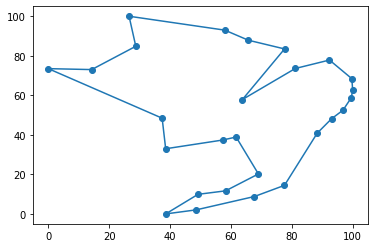

Route: [ 0 15 11 19 13  1 22 26 21  9 17  8 24  3  5 10  6  7 20 18 14  4 12  2
 23 16 25]

Distance_scaled: 422.3405991814746


In [ ]:
#PLOT IN CARTESIAN 


import matplotlib.pyplot as plt
# Reorder the cities matrix by route order in a new matrix for plotting.
new_cities_order = np.concatenate((np.array([scaled[route[i]] for i in range(len(route))]),np.array([scaled[0]])))
# Plot the cities.
plt.scatter(scaled[:,0],scaled[:,1])
# Plot the path.
plt.plot(new_cities_order[:,0],new_cities_order[:,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(route) + "\n\nDistance_scaled: " + str(path_distance(route,scaled)))


In [ ]:
#unit of scale = ()Max (Lng or Lat) - Min(Lng or Lat)) /100
#unit of scale = 53.31km

Distance_km = path_distance(route,scaled) * 53.31
Distance_km

22514.97734236441

Portanto, a distância total é de 23050 km

In [ ]:
order = pd.DataFrame(route, columns=["index"])
cities2["index"] = cities2.index
cities2
travel=order.merge(cities2, on = "index")




In [ ]:

start= travel[0:1]
loop = travel.append(start)
loop


,index,nome,descricao,latitude,longitude,lat_radians,lon_radians,x,y
0,0,Fortaleza,Ceará,-3.716640,-38.5423,-0.064868,-0.672690,4972.586968,-323.012994
1,15,Natal,Rio Grande Do Norte,-5.793570,-35.1986,-0.101117,-0.614331,5179.527247,-525.529930
2,11,João Pessoa,Paraíba,-7.115090,-34.8641,-0.124182,-0.608493,5187.215605,-647.489257
3,19,Recife,Pernambuco,-8.046660,-34.8771,-0.140441,-0.608720,5175.184638,-731.623024
4,13,Maceió,Alagoas,-9.665990,-35.7350,-0.168703,-0.623693,5098.093783,-868.318866
5,1,Aracaju,Sergipe,-10.909100,-37.0677,-0.190400,-0.646953,4991.705945,-962.073286
6,22,Salvador,Bahia,-12.971800,-38.5011,-0.226401,-0.671971,4858.683044,-1119.196831
7,26,Vitória,Espirito Santo,-20.315500,-40.3128,-0.354572,-0.703591,4555.845123,-1686.659544
8,21,Rio de Janeiro,Rio de Janeiro,-22.912900,-43.2003,-0.399906,-0.753987,4277.795699,-1808.146751
9,9,Florianópolis,Santa Catarina,-27.594500,-48.5477,-0.481615,-0.847317,3737.820630,-1953.628557


# Plotar Latitude e Longitude

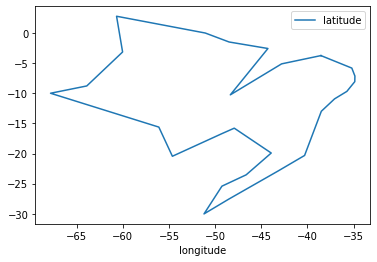

In [ ]:
loop.plot(kind="line", x="longitude", y="latitude")

# Exportar arquivo CSV com a rota

In [ ]:
# Escrevendo o arquivo CSV com rota

tsp = loop[["latitude", "longitude"]]

tsp.to_csv('mandalore_rota_pcv.csv', index=False)

from google.colab import files
files.download("mandalore_rota_pcv.csv")





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

csv disponível em: https://github.com/alisio/tsp/blob/master/tsp.csv

Utilize o arquivo csv contendo latitude e longitude aqui para visualização: http://www.gpsvisualizer.com/draw/ 

# Conclusão

 2-opt  swap algorithm was used.
 

**A distância mais curta é de 23,050 km**

**A rota contempla todas as capitais dos estados do Brasil**

A imagem abaixo ilustra a rota mais curta definida pelo algoritmo PCV™, iniciando pela capital cearense, Fortaleza. 

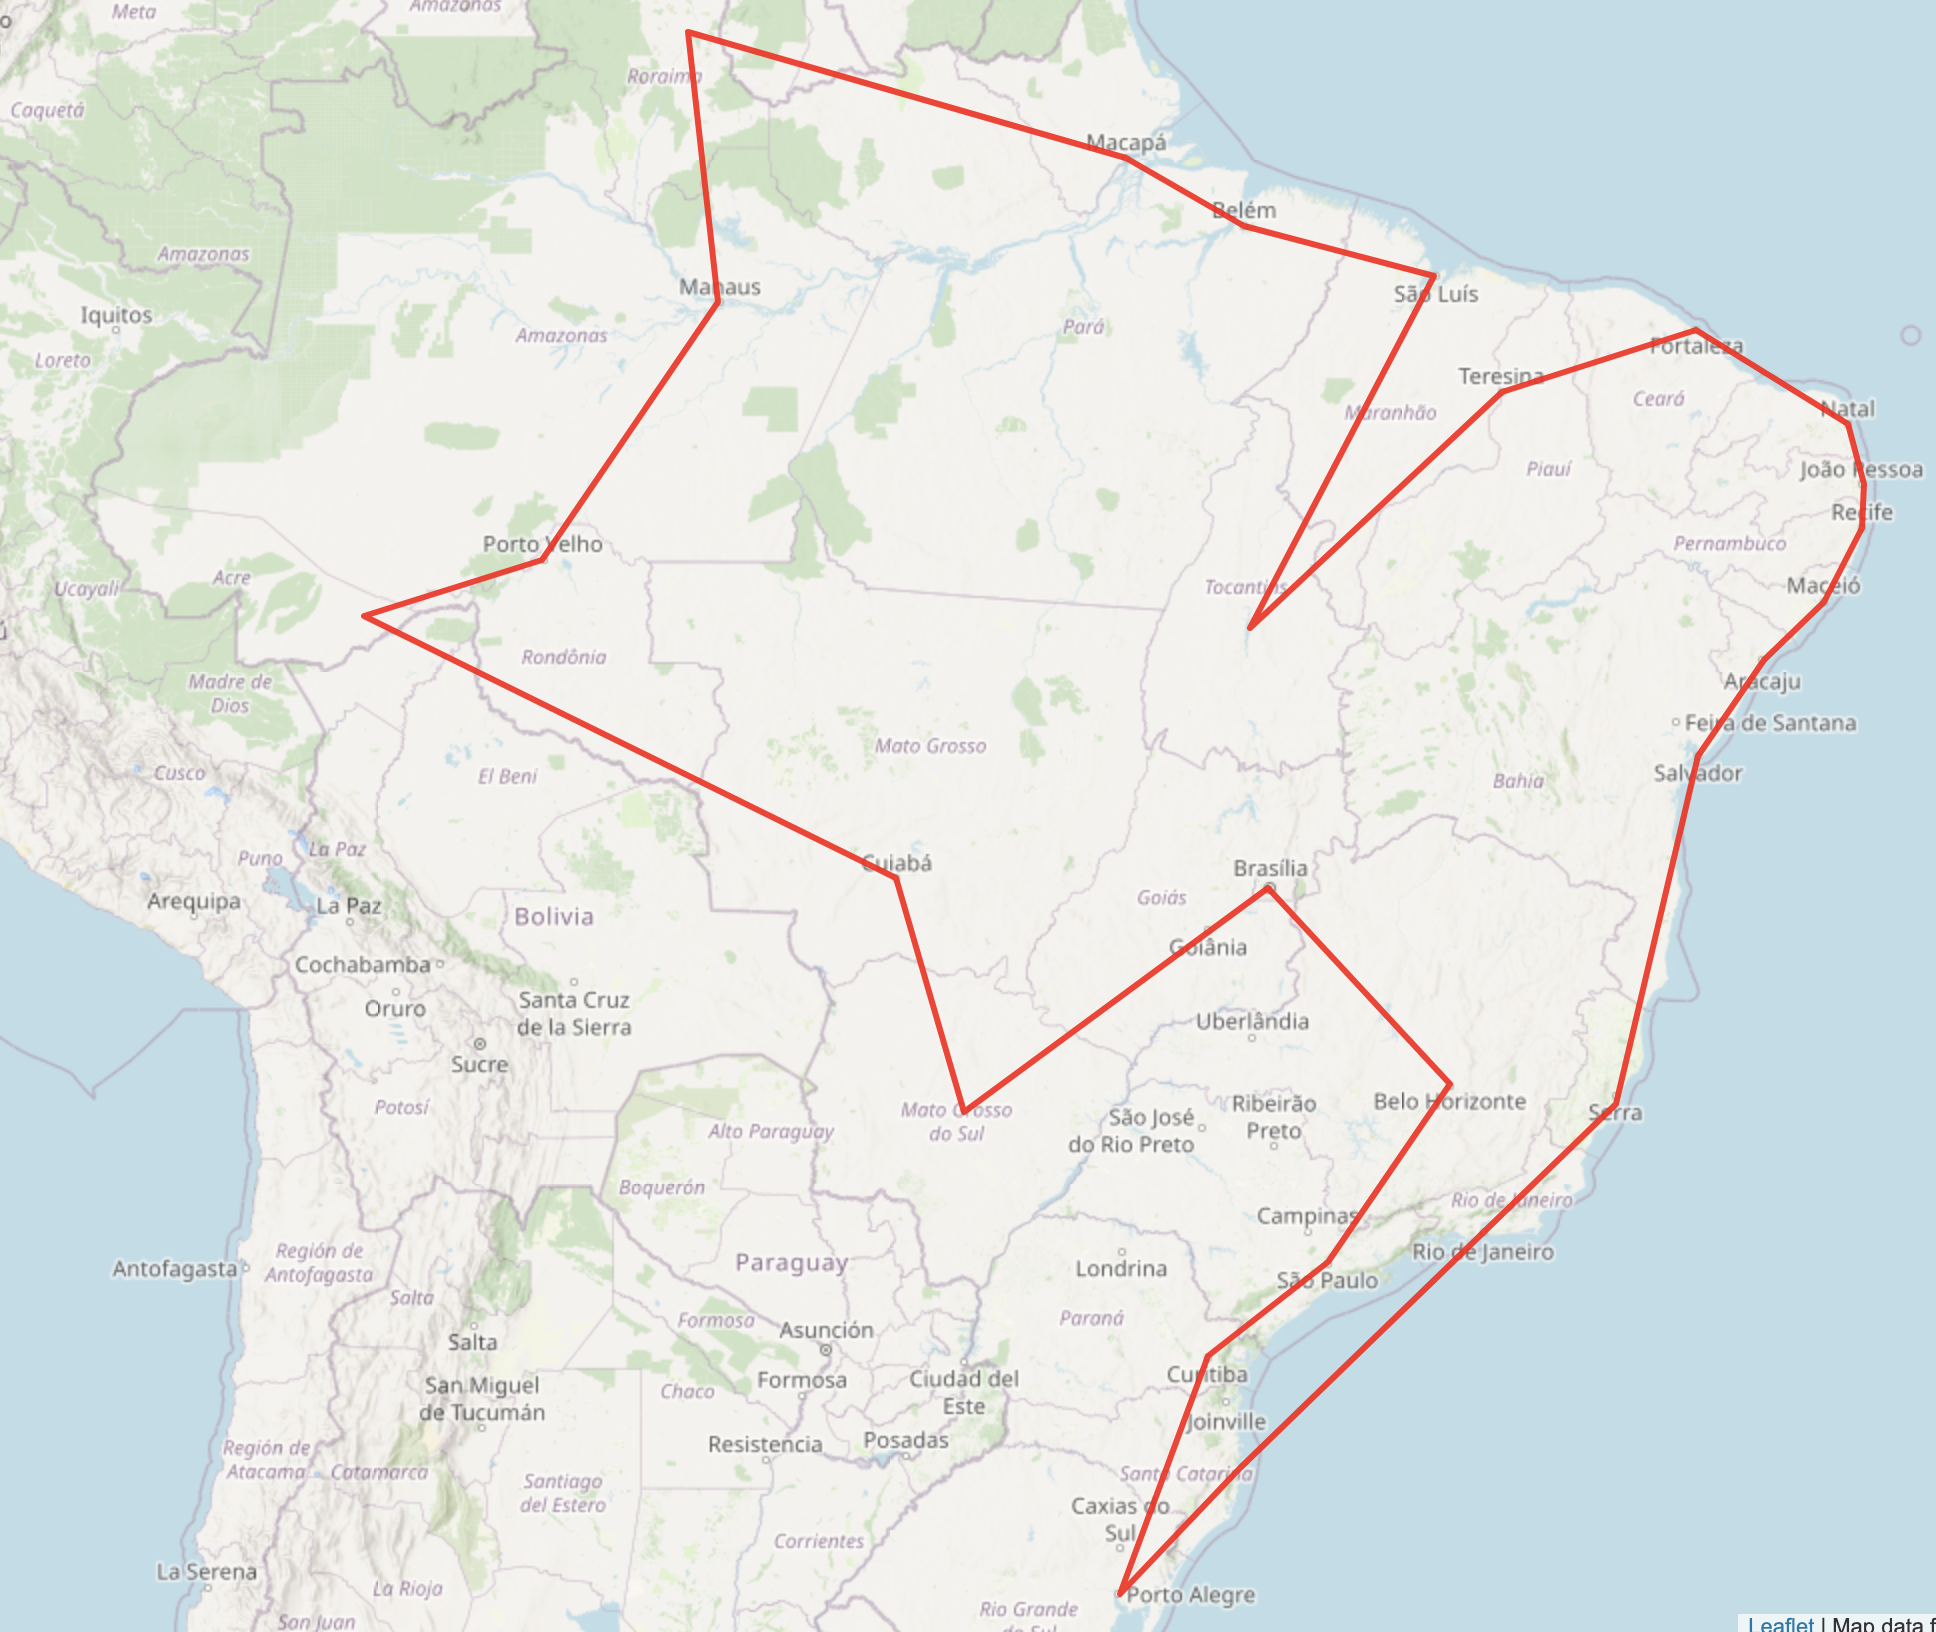

# Referências

GEO MIDPOINT. **Geographic Midpoint Calculation Example**. Disponível em \<http://www.geomidpoint.com/example.html>. Acesso em 17 de agosto de 2020.


IBGE. **IBGE disponibiliza coordenadas e altitudes para 21.304 localidades brasileiras**. Disponível em \<https://agenciadenoticias.ibge.gov.br/agencia-sala-de-imprensa/2013-agencia-de-noticias/releases/14126-asi-ibge-disponibiliza-coordenadas-e-altitudes-para-21304-localidades-brasileiras>. Acesso em 17 de agosto de 2020.


PRADO, Kelvin. **Github - kelvins/Municipios-Brasileiros**. Disponível em \<https://github.com/kelvins/Municipios-Brasileiros>. Acesso em 17 de agosto de 2020.


TAYLOR, Roy. **Travelling Salesman in scipy**
. Disponível em \<https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy>. Acesso em 17 de agosto de 2020

VIASAT. **Viasat passa a fornecer internet a bordo para aviões da Aeroméxico** .Disponível em \<https://viasatdobrasil.com.br/viasat-passa-a-fornecer-internet-a-bordo-para-avioes-da-aeromexico/>. Acesso em 18 de agosto de 2020

WIKIPEDIA. **2-opt**. Disponível em \<https://en.wikipedia.org/wiki/2-opt>. Acesso em 18 de agosto de 2020.

WIKIPEDIA. **Problema do Caixeiro Viajante**. Disponível em \<https://pt.wikipedia.org/wiki/Problema_do_caixeiro-viajante>. Acesso em 17 de Agosto de 2020.